# HOMEWORK PART 2b

---

## Download the accompanying ZIP file which includes MATLAB code for solving (i) A reaction-diffusion system of equations, and (ii) The Kuramoto-Sivashinsky (KS) equation.
3. For the reaction-diffusion system, first project to a low-dimensional subspace via the SVD and see how forecasting works in the low-rank 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc
import matplotlib.gridspec as gridspec
from scipy import integrate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

import os

import torch
import torch.utils.data as Data
torch.manual_seed(113)    # reproducible results
np.random.seed(113)
seed = 113

rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

In [2]:
colors = [(0, 0, 0), (0.5, 0.5, 0.5), (1, 1, 1), (1, 0, 0.5), (0.5, 0., 1)]
cmap_name = 'dark_purple'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=100)

In [3]:
def rhs_reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    # Calculate u and v terms
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N:], (n, n))
    u = np.real(np.fft.ifft2(ut))
    v = np.real(np.fft.ifft2(vt))
    
    # reaction terms
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((np.fft.fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((np.fft.fft2(v - v3 - u2v - beta * u3 - beta * uv2)), (N, 1))
    
    rhs = np.concatenate([-d1 * K22 * uvt[:N] + utrhs,
           -d2 * K22 * uvt[N:] + vtrhs])[:, 0]

    return rhs

In [4]:
def DMD(X, dX, r, time):
    """Apply Dynamic Mode Decomposition (DMD)
    
        Parameters
    ----------
    X : array
        State matrix size: features x time.
    dX : array
        Time shifted state matrix.
    time : array
        Time steps.
    r : int
        Rank truncation.

    Returns
    -------
    U, V, S : array
        Singular Value Decomposition (SVD) of X.
    x_dmd : array
        DMD reconstruction.
    
    """
    dt = time[1] - time[0]
    
    # SVD on the state matrix
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    V = Vh.conj().T
    U = U[:, :r]
    V = V[:, :r]
    S = S[:r]
    
    # Projection of state matrix onto U
    A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
    
    # Eigenvalues
    Lambda, W = np.linalg.eig(A_tilde)
    
    # Eigenvectors
    Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W
    
    
    X0 = X[:, 0] # initial conditions

    omega = np.log(Lambda) / dt

    b = np.linalg.pinv(Phi) @ X0


    # Reconstruction
    x_dmd = np.zeros((r, len(time)), dtype=omega.dtype)
    for k in range(len(time)):
        x_dmd[:, k] = b * np.exp(omega * time[k])
    x_dmd = np.dot(Phi, x_dmd)
    
    #x_k = np.zeros((r, len(t_new)), dtype=omega.dtype)
    #for k in range(len(t_new)):
    #    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b
    
    return U, S, V, x_dmd   

In [5]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = torch.tanh(self.linear2(h_relu))
        h_relu = torch.sigmoid(self.linear3(h_relu))
        y_pred = self.linear4(h_relu)
        return y_pred

In [6]:
dt = 0.05
final_t = 10
t = np.linspace(0, final_t, int(final_t/dt)+1)
d1 = 0.1
d2 = 0.1 
beta = 1.0
L = 20 
n = 32
N = n * n
x2 = np.linspace(-L/2, L/2, n+1) 
x = x2[0: n]
#y = np.copy(x)
y = x
kx = (2 * np.pi / L) * np.concatenate([np.arange(0, n/2), np.arange(-n/2, 0)])
ky = kx

# Initial conditions
[X, Y] = np.meshgrid(x, y)
[KX, KY] = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N,1))

m = 1 # number of spirals

u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j*Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j*Y) - (np.sqrt(X ** 2 + Y ** 2)))
    
# Reaction diffusion
uvt = np.concatenate([np.reshape(np.fft.fft2(u[:, :, 0]).T, (N, 1)), np.reshape(np.fft.fft2(v[:, :, 0]).T, (N, 1))])
sol = integrate.solve_ivp(rhs_reaction_diffusion, [0, final_t], uvt[:, 0], args=(K22, d1, d2, beta, n, N), method = 'RK45', t_eval=t)
uvsol = sol.y

for j in range(len(t)-1):
    ut = np.reshape(uvsol[:N,j+1], (n, n))
    vt = np.reshape(uvsol[N:,j+1], (n, n))
    u[:, :, j+1] = np.real(np.fft.ifft2(ut))
    v[:, :, j+1] = np.real(np.fft.ifft2(vt))

np.savez('reaction_diffusion_big.npz', t=t, x=x, y=y, u=u, v=v)

In [7]:
print('- - - - -')
print('Problem info:')
print('- - - - -')
print("Point along x : {}".format(v.shape[0]))
print("Point along y : {}".format(v.shape[1]))
print("Time step : {}".format(v.shape[2]))
print('- - - - -')

- - - - -
Problem info:
- - - - -
Point along x : 32
Point along y : 32
Time step : 201
- - - - -


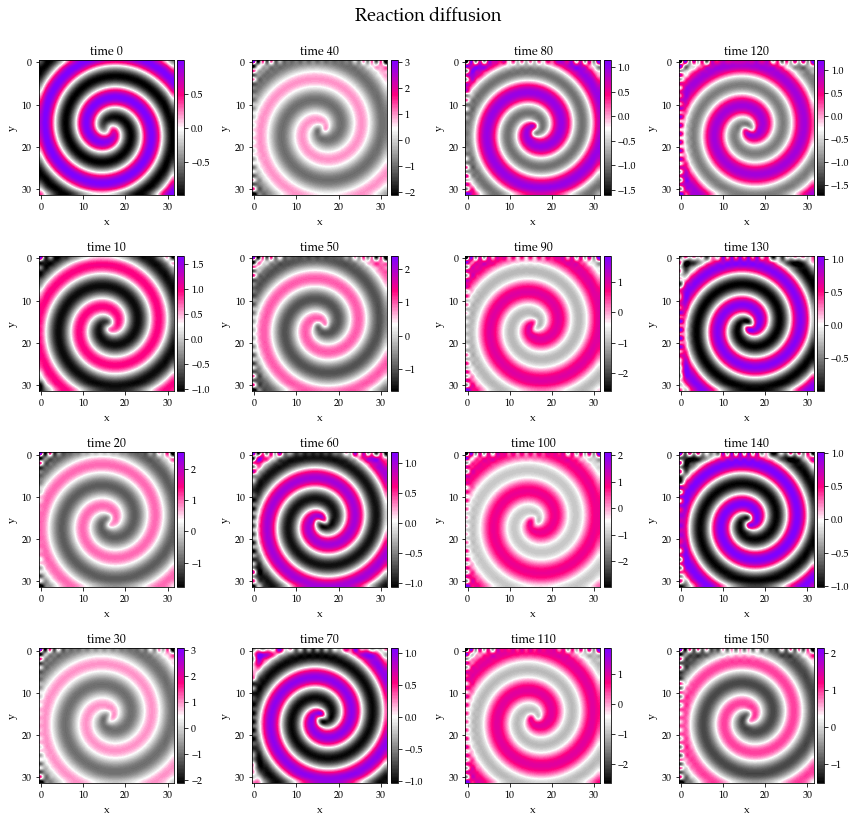

In [8]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Reaction diffusion", fontsize=18)
gs = gridspec.GridSpec(4, 4)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)   
k = -1
j = 0

for _time in np.arange(0, 160, 10):

    if j % 4 == 0:
        k += 1
        
    ax = plt.subplot(gs[j%4, k])
    h = ax.imshow(u[:, :, _time], interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % _time, fontsize = 12)
    
    j += 1
    
gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/RD.pdf', format='pdf', dpi=1200)

Generate training and test dataset flattening v.

In [9]:
xy_dim = v.shape[0]
t_dim = v.shape[2]
n_test_time = int(t_dim * 0.2)
v_flat = np.reshape(v, (xy_dim ** 2, t_dim))

In [10]:
X = np.copy(v_flat)

U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T

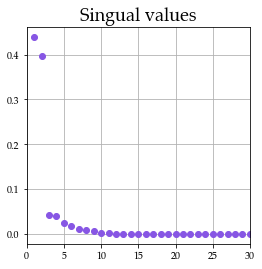

In [30]:
fig = plt.figure(figsize=(4, 4))
plt.plot(range(1,len(S)+1), S / np.sum(S), 'o', linewidth='2', color='xkcd:purpley')
plt.title('Singual values', fontsize = 18)
plt.xlim([0, 30])
plt.grid()

Reduce the space dimension of X

In [11]:
r = 14
Ur = U[:, :r]
Vr = V[:, :r]
Sr = S[:r]

_X_reduced = Ur.conj().T @ X
X_reduced = _X_reduced[:, :-1]
dX_reduced = _X_reduced[:, 1:]

Split the data

In [12]:
# train data
X_train = X_reduced[:, :-n_test_time].T
dX_train = dX_reduced[:, 1:-n_test_time+1].T
# test data
X_test = X_reduced[:, -n_test_time:-1].T
dX_test = dX_reduced[:,-n_test_time+1:].T

In [13]:
batch = 1

train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(dX_train).float())
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)

In [14]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        y_pred = self.linear4(h_relu)
        return y_pred

In [15]:
n_x = X_train.shape[1]
D_in, H, D_out = n_x, 100, n_x

epochs = 390

model1 = MLPNN(D_in, H, D_out)

if(os.path.isfile('weights_NN')):
    model1.load_state_dict(torch.load('weights_NN'))
    print(model1.eval())
else:
    criterion = torch.nn.MSELoss(reduction='mean') 
    optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model1(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print("Iteration: ", epoch, " Loss: ", loss.item())
    torch.save(model1.state_dict(), 'weights_NN')

MLPNN(
  (linear1): Linear(in_features=14, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=14, bias=True)
)


In [49]:
_X_test = torch.from_numpy(X_test).float()
_dX_test = torch.from_numpy(dX_test).float()

test_prediction = X_test[None, 0, :]
with torch.no_grad():
    for i in range(1, _X_test.shape[0]):
        curr_pred = model1(torch.from_numpy(test_prediction[i-1, :]).float())
        test_prediction = np.vstack((test_prediction, curr_pred))

In [50]:
_forecast = Ur @ test_prediction.T
_real = Ur @ dX_test.T
forecast = np.reshape(_forecast, (xy_dim, xy_dim, -1))
real = np.reshape(_real, (xy_dim, xy_dim, -1))

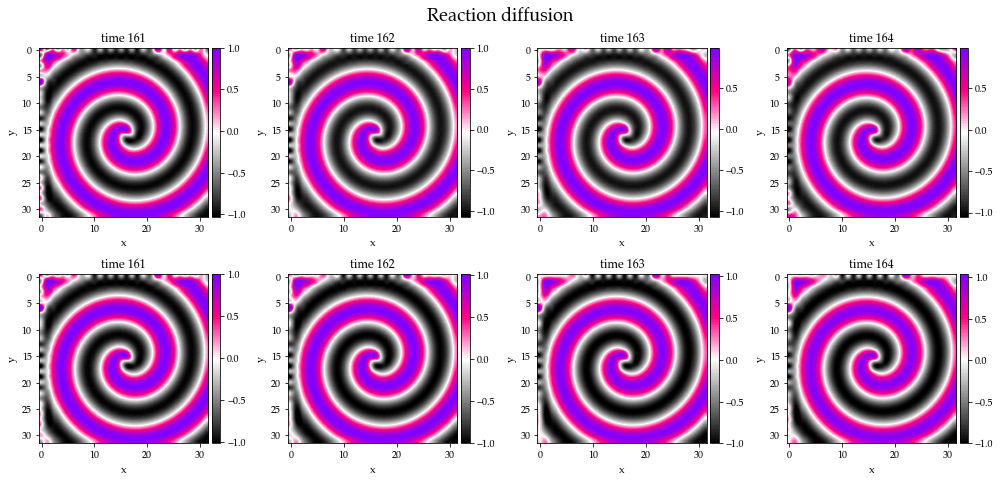

In [60]:
tmp = len(t) - n_test_time
fig = plt.figure(figsize=(14, 7))
fig.suptitle("Reaction diffusion", fontsize=18)
gs = gridspec.GridSpec(2, 4)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)   
j = 0

for _time in [0, 1, 2, 3]:
    
    tmp_time = tmp + _time
    ax = plt.subplot(gs[0, j])
    h = ax.imshow(forecast[:, :, _time], interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % tmp_time, fontsize = 12)
    
    ax = plt.subplot(gs[1, j])
    h = ax.imshow(real[:, :, _time], interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % tmp_time, fontsize = 12)
    
    j += 1
    
gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/forecast_RD.pdf', format='pdf', dpi=1200)

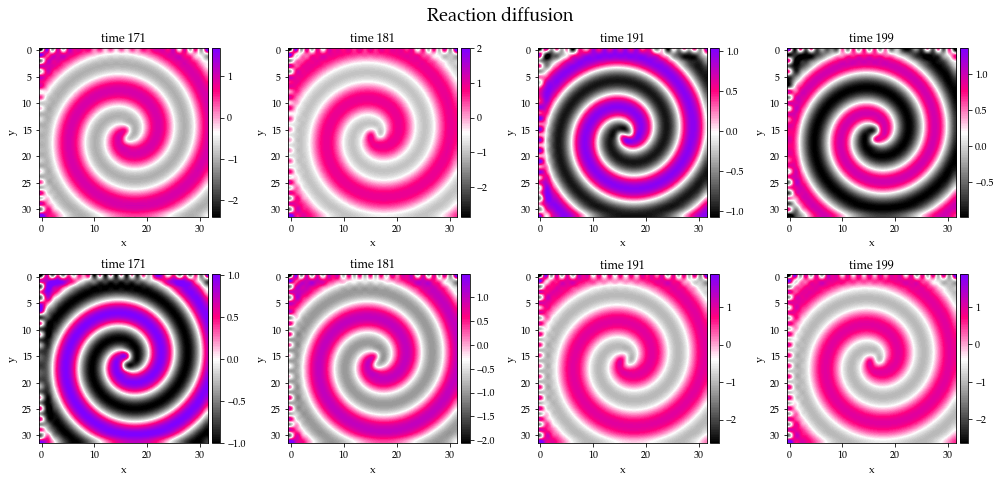

In [63]:
tmp = len(t) - n_test_time
fig = plt.figure(figsize=(14, 7))
fig.suptitle("Reaction diffusion", fontsize=18)
gs = gridspec.GridSpec(2, 4)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)   
j = 0

for _time in [10, 20, 30, 38]:
    
    tmp_time = tmp + _time
    ax = plt.subplot(gs[0, j])
    h = ax.imshow(forecast[:, :, _time], interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % tmp_time, fontsize = 12)
    
    ax = plt.subplot(gs[1, j])
    h = ax.imshow(real[:, :, _time], interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % tmp_time, fontsize = 12)
    
    j += 1
    
gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/forecast_RD2.pdf', format='pdf', dpi=1200)

In [ ]:
dmd = False
if dmd:
    r = 14

    U, S, V, x_dmd = DMD(X, dX, r, t)
    reconstruction = np.reshape(x_dmd, (xy_dim, xy_dim, t_dim))
    U_resh = np.reshape(U, (xy_dim, xy_dim, -1))

Let's see how model work for training data.

In [ ]:
if dmd:
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Reaction diffusion", fontsize=18)
    gs = gridspec.GridSpec(1, 3)

    gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

    ax = plt.subplot(gs[0, 0])
    h = ax.imshow(np.real(U_resh[:, :, 0]), interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('U1', fontsize = 12)

    ax = plt.subplot(gs[0, 1])
    h = ax.imshow(np.real(U_resh[:, :, 1]), interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('U2', fontsize = 12)

    ax = plt.subplot(gs[0, 2])
    h = ax.imshow(np.real(U_resh[:, :, 2]), interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('U3', fontsize = 12)

In [ ]:
if dmd:
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Reaction diffusion", fontsize=18)
    gs = gridspec.GridSpec(1, 3)

    gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

    ax = plt.subplot(gs[0, 0])
    h = ax.imshow(np.real(reconstruction[:, :, 0]), interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('DMD1', fontsize = 12)

    ax = plt.subplot(gs[0, 1])
    h = ax.imshow(np.real(reconstruction[:, :, 1]), interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('DMD2', fontsize = 12)

    ax = plt.subplot(gs[0, 2])
    h = ax.imshow(np.real(reconstruction[:, :, 2]), interpolation='lanczos', cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('DMD3', fontsize = 12)